In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import truncnorm

import matplotlib.pyplot as plt
import plotnine as p9

import local_conformal as lc

import ipdb

import progressbar
import itertools

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import io
from PIL import Image

In [4]:
import warnings

In [69]:
import re

# Hyper parameters

In [5]:
n = 100
num_groups = 4


# Data Generation

## Distribution functions

In [6]:
def my_bimodal(n):
    """
    defines a bimodal distribution (with mean 1, overall sd = 1, and pi = .5)
    
    Args:
    -----
    n : int number of samples to draw
    
    Returns:
    --------
    vector of random samples
    """
    group_idx = np.random.binomial(n = 1, p = 0.5, size = n)
    value = group_idx*np.random.normal(0.25, 0.4375, size = n) +\
        (1-group_idx)*np.random.normal(1.75, 0.4375, size = n)
    return value



def data_generation(n, sigma_num = 4):
    """
    This function generates x,y and group values  
    
    xvals = noisy group numbers.
    
    Where the overall y distribution is distributed:
    (1) N(1,1), 
    (2) Unif(1-sqrt(3), 1+sqrt(3))
    (3) Exp(1)
    or (4) 0.5N(0.25,0.4375) + 0.5N(1.75,0.4375),
    
    and we scale the sigmas by 4^(0:sigma_num)
    
    Args:
    -----
    n : int, number of y values for each group
    sigma_num : int, number of sigma groups
    
    Returns:
    -------
    y_vec : numpy vector of length n*sigma_num*4, where
    n*(i*j-1):n*(i*j) values are associated with the ith overall distribution,
    with the jth sigma value scaling.
    """
    sigma_values = 4**np.arange(sigma_num)
    num_groups = sigma_num*4


    # x and group values:
    group_list = []
    for idx in np.arange(num_groups, dtype = np.int):
        group_list += [idx]*n

    group_info = np.array(group_list)
    add_noise = np.random.uniform(low = -.45, high = .45, size = num_groups*n)

    x = group_info + add_noise



    # y values

    y_generate_base = [lambda n : np.random.normal(1,1, size = n), 
                   lambda n : np.random.uniform(1 - np.sqrt(3), 
                                                1 + np.sqrt(3), 
                                                size = n),
                   lambda n : np.random.exponential(1, size = n),
                   my_bimodal]

    y_generate_all = []
    for sigma_idx in np.arange(sigma_num , dtype = np.int):
        current_sigma = sigma_values[sigma_idx]
        for f_idx in np.arange(4, dtype = np.int):

            y_generate_all += [lambda n : current_sigma.copy() * y_generate_base.copy()[f_idx](n)]


    y_list = []
    for sigma_idx in np.arange(sigma_num , dtype = np.int):
        current_sigma = sigma_values[sigma_idx]
        for f_idx in np.arange(4, dtype = np.int):
            current_function = lambda n : current_sigma * y_generate_base[f_idx](n)
            y_list += list(current_function(n))
    y = np.array(y_list)

    data_all = pd.DataFrame(data = {"x" : x, "y" : y,
                                "group_info" : group_info})

    return(data_all)
    

## Demo data creation

In [7]:
demo_data = data_generation(500,4)

### Demo data visualization

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


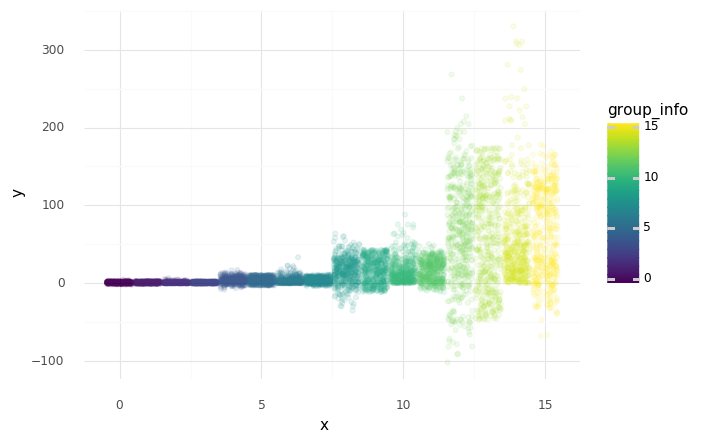

<ggplot: (8772373711869)>

In [8]:
assert demo_data.shape == (16*500,3)

p9.ggplot(demo_data) + \
    p9.geom_point(p9.aes(x="x",y="y", color = 'group_info'), alpha = .1) +\
    p9.theme_minimal()

# Data Splitting

## function and test

In [9]:
def stratified_data_splitting(data, group_col = "group_info", 
                              prop_vec = np.array([1/3,1/3,0,0,1/3])):
    """
    splits pd.DataFrame into any number of subsets
    
    Args:
    -----
    data : pd.DataFrame to split
    group_col : string (or list) of column(s) to group by
    prop_vec : np vector of proportions for each new data split.
    """
    
    assert np.sum(prop_vec) == 1 and np.all(prop_vec >= 0), \
        "prop_vec should be a proper proportion vector (non-neg and sum to 1)"
    
    list_group_info = [group for _, group in data.groupby(group_col)]

    n_out = prop_vec.shape[0]
    n_groups = len(list_group_info)
    list_data = []
    for group_idx in np.arange(n_groups, dtype = np.int):
        inner_nrow = list_group_info[group_idx].shape[0]
        inner_row_vec = np.random.choice(inner_nrow, size = inner_nrow, 
                                         replace = False)
        #ipdb.set_trace()
        inner_group_vec = np.random.choice(n_out, size = inner_nrow, 
                                           p = prop_vec)
        
        for split_idx in np.arange(n_out, dtype = np.int):
            #ipdb.set_trace()
            current_data = list_group_info[group_idx].iloc[
                np.array(inner_row_vec[inner_group_vec == split_idx], 
                         dtype = np.int)]
            if group_idx == 0:
                list_data.append(current_data)
            else:
                list_data[split_idx] = list_data[split_idx].append(current_data, 
                                                                   ignore_index = True)
    
            
    return(list_data)
            

In [10]:
def test_stratified_data_splitting():
    data = pd.DataFrame(data = {"x": np.arange(120),
                               "group": [1]*40+[2]*40+[3]*40})
    for seed in [1,3]:
        np.random.seed(seed)
        out1 = stratified_data_splitting(data, group_col = "group", 
                                         prop_vec = np.array([.5,.5]))
        if seed == 1:
            assert out1[0].shape == (59,2) and out1[1].shape == (61,2), \
                "sizes should be fixed around .5/.5"
        if seed == 3:
            assert out1[0].shape == (60,2) and out1[1].shape == (60,2), \
                "sizes should be fixed around .5/.5"

        x_vals = np.array(out1[0].append(out1[1], ignore_index = True).x)
        x_vals.sort()
        assert np.all(x_vals == np.arange(120)), \
            "all data should be included 1 time between either of the " +\
            "sub data frames"
        
test_stratified_data_splitting()

In [11]:
data_list = stratified_data_splitting(demo_data, group_col = "group_info", 
                                     prop_vec = np.array([.5,.5]))

In [12]:
x_train_torch = torch.from_numpy(np.array(data_list[0].x).reshape((-1,1))).float()
y_train_torch = torch.from_numpy(np.array(data_list[0].y).reshape((-1,1))).float()

x_val_torch = torch.from_numpy(np.array(data_list[1].x).reshape((-1,1))).float()
y_val_torch = torch.from_numpy(np.array(data_list[1].y).reshape((-1,1))).float()

# Models

## MDN Perceptron

In [13]:
class MDNPerceptron(nn.Module):
    def __init__(self, n_hidden1, n_hidden2, n_gaussians):
        """
        create a multiple hidden layer MDN Perceptron for a 1D input (output is 
        also in 1D space).
        
        Args:
        -----
        n_hidden1: int, number of nodes in the first hidden layer
        n_hidden2: int, number of nodes in the second hidden layer
        n_guassians: int, number of gaussians in final output layer
        
        """
        super().__init__()
        
        self.base_model = nn.Sequential(
            nn.Linear(1, n_hidden1),
            nn.Sigmoid(),
            nn.Linear(n_hidden1, n_hidden2),
            nn.Sigmoid())
        
        self.z_pi = nn.Sequential(
            nn.Linear(n_hidden2, n_gaussians),
            nn.Softmax(dim = 1))
        self.z_mu = nn.Linear(n_hidden2, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden2, n_gaussians)
        
        self.y_range = None
        self.n_grid = None
        

    def forward(self, x):
        """
        Returns parameters of for a mixture of gaussians given x
        
        Args:
        -----
        x: data x value (n, 1) torch.Tensor
        
        Returns:
        --------
        pi: probability distribution over the gaussians
        mu: vector of means of the gaussians
        sigma: vector representing the diagonals of the covariances of the 
            gaussians
        """
        inner = self.base_model(x)
        
        pi = self.z_pi(inner) 
        mu = self.z_mu(inner)
        sigma = torch.exp(self.z_sigma(inner)) # to get positive

        return pi, mu, sigma
        
    def sample(self, pi, mu, sigma):
        """
        Makes a random draw from a randomly selected mixture based on parameters
        
        Args:
        -----
        pi: probability distribution over the gaussians
        mu: vector of means of the gaussians
        sigma: vector representing the diagonals of the covariances of the 
            gaussians
        """
        mixture = torch.normal(mu, sigma)
        k = torch.multinomial(pi, 1, replacement=True).squeeze()
        result = mixture[range(k.size(0)), k]
        return result
    
    def loss_fn(self, y, pi, mu, sigma):
        """
        Computes the mean probability of the datapoint being drawn from all the 
        gaussians parametized by the network.
    
        
         Args:
        -----
        y: potential vector of y values (n, 1) torch.Tensor
        mu: vector of means of the gaussians (n, n_guassians)
        sigma: vector representing the diagonals of the covariances of the 
            gaussians (n, n_guassians)
        pi: probability distribution over the gaussians (n, n_guassians)
        
        Details / Notes:
        ----------------
        I'm slightly worried about the numerical stability given this is going
        back and forth between log() and exp().
        
        
        similar thoughs in tensorflow: https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca
        pytorch mixtures: https://pytorch.org/docs/stable/distributions.html
        """
        
        mixture = torch.distributions.normal.Normal(mu, sigma)
        log_prob_x = mixture.log_prob(y.reshape(-1,1))
        log_mix_prob = torch.log(pi)  # [B, k]
        return -torch.mean(torch.logsumexp(log_prob_x + log_mix_prob, dim=-1))
        
    def prep_for_cde(self, y_values, n_grid):
        """
        initialize paramters to allow for self.cde_predict_grid to analysis
        over a grid of y_values
        
        Arguments:
        ----------
        y_values: numpy or torch vector, either the min and max of the range or 
            a list of y_values, which we will take the min and max of.
        n_grid: int, number of equally spaced point to be done on the grid
        """
        self.y_range = (y_values.min(), y_values.max())
        self.n_grid = n_grid
    
    def cde_predict_grid(self, x_values):
        """
        calculate the estimated conditional density estimate across a grid 
        of y_values (and defind by internal self.y_range and self.n_grid -- set
        using the self.prep_for_cde function)
        
        Arguments:
        ----------
        x_values:  data x value (n, 1) torch.Tensor
        
        Returns:
        --------
        tensor matrix (n, self.n_grid) where each value [i,j] 
            is the CDE estimates conditonal on x[i] for yy[j] where 
            yy is a sequence of equally spaced y values ranging from 
            self.y_range[0] to self.y_range[1] (with n_grid points on this 
            range)
        
        """
        
        
        if self.y_range is None or self.n_grid is None:
            raise LookupError("need to run prep_for_cde first to" +\
                              "define self.y_range and self.n_grid")
        
        y_grid = torch.from_numpy(np.linspace(self.y_range[0],
                                              self.y_range[1],
                                              self.n_grid)).float()
        pi, mu, sigma = self.forward(x_values)
        mixture = torch.distributions.normal.Normal(mu, sigma)
        log_mix_prob = torch.log(pi)  
            
        log_prob_x_list = []
        
        for yy in y_grid:
            log_prob_x_list.append(mixture.log_prob(yy.repeat(pi.shape[0],1)).unsqueeze(2))
        
        log_prob_x_mat = torch.cat(log_prob_x_list, dim = 2)
        
        return torch.exp(torch.logsumexp(log_prob_x_mat + \
                                         log_mix_prob.unsqueeze(2).repeat(1,1,log_prob_x_mat.shape[2]), 
                                         dim = 1))
        
        
    def cde_predict(self, x_values, y_values):
        """
        evaluate the estimated conditional density estimate on y_value[i] given
        x_values[i]
        
        Arguments:
        ----------
        x_values:  data x value (n, 1) torch.Tensor
        y_values: data y value (n,1) torch.Tensor
        
        Returns:
        --------
        tensor vector (n, 1) where each value [i,] 
            is the CDE estimates conditonal on x_values[i] for y_values[j] 
        """
        pi, mu, sigma = self.forward(x_values)
        mixture = torch.distributions.normal.Normal(mu, sigma)
        log_prob_x = mixture.log_prob(y_values.reshape(-1,1))
        log_mix_prob = torch.log(pi)  # [B, k]
        return torch.exp(torch.logsumexp(log_prob_x + log_mix_prob, dim=-1))
        


In [14]:
def tune_first_nn(x_train, y_train, x_val, y_val, 
                  model_op_list = None, epochs=10000, 
                  n_gaussians=3, n_hidden1=10, n_hidden2 = 10, lr=1e-3, 
                  verbose = False):
    """
    create and evalulate a MDN Perceptron
    
    Args:
    -----
    x_train: torch.Tensor (n, 1), training x
    y_train: torch.Tensor (n, 1), training y
    x_val: torch.Tensor (m, 1), validation x
    y_val: torch.Tensor (m, 1), validation y
    model_op_list : list with model and optimizer already created - else 
        will create them ourselves (Default is: None)
    epochs : int number of epochs to train the model for
    n_guassians : int, number of guassians to be included in the MDN Perceptron
    n_hidden1 : int, number of nodes for first hidden layer
    n_hidden2 : int, number of nodes for second hidden layer
    lr : float, learning rate for the optimizer (default is Adam)
    verbose : boolean, if we should be verbose about the learning across epochs.
    
    Returns:
    --------
    tuned model, associated optimizer, and validation error
    """
    # model creation if necessary ------
    if model_op_list is None:
        model = MDNPerceptron(n_hidden1, n_hidden2, n_gaussians)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        model = model_op_list[0]
        optimizer = model_op_list[1]
    
    # verbosity for fit ------
    if verbose:
        bar = progressbar.ProgressBar(widgets = [ progressbar.Bar(),
                                              ' (', progressbar.ETA(), ", ", 
                                              progressbar.Timer(), ')'])
        epoch_iter = bar(np.arange(epochs))
    else:
        epoch_iter = range(epochs)
    
    # actual fit ------
    for epoch in epoch_iter:
        optimizer.zero_grad()
        pi, mu, sigma = model(x_train)
        loss = model.loss_fn(y_train, pi, mu, sigma)
        loss.backward()
        optimizer.step()
        
    # get validation error -------
    pi_v, mu_v, sigma_v = model(x_val)
    error = model.loss_fn(y_val, pi_v, mu_v, sigma_v)
    
    return model, optimizer, error

In [15]:
tune_out = tune_first_nn(x_train = x_train_torch, 
              y_train = y_train_torch, 
              x_val = x_val_torch, 
              y_val = y_val_torch, 
              model_op_list = None, 
              epochs=10000, 
              n_gaussians=4, 
              n_hidden1=10, 
              n_hidden2 = 10, 
              lr=1e-3, 
              verbose = True)

|#####################################| (Time:  0:00:43, Elapsed Time: 0:00:43)


In [16]:
mdn_model = tune_out[0]


In [17]:
if False: # just a check
    model = tune_out[0]
    pi_v, mu_v, sigma_v = model(x_val_torch)
    error = model.loss_fn(y_val_torch, pi_v, mu_v, sigma_v)
    pi_v 

### Visualizing fit...

Approach take a sequence of 10 x values in a range for a single group. 

In [18]:
def visualize_model_fit(group_id, model, yy_grid=None):
    """
    group_id needs to be an int
    """
    
    if yy_grid is None:
        sigma = 4**((group_id-1) // 4)
        yy_grid = np.linspace(-4*sigma, 4*sigma, num = 1000)
    
    n_y = yy_grid.shape[0]
    
    x = group_id + np.linspace(-.45, .45, num = 11)
    #x_torch = torch.from_numpy(x.reshape((-1,1))).float()
    
    #pi, mu, sigma = model(x_torch)
    
    x_values = []
    x_idx_vec = []
    yy = []
    cde = []
    
    for x_idx in range(11):
        xx_grid = [x[x_idx]] * n_y
        x_values += xx_grid
        x_idx_vec += [x_idx] * n_y
        yy += list(yy_grid)
        #ipdb.set_trace()
        
        xvec_torch = torch.from_numpy(np.array(xx_grid).reshape((-1,1))).float()
        yvec_torch = torch.from_numpy(yy_grid.reshape((-1,1))).float()
        
        cde += list(model.cde_predict(xvec_torch, yvec_torch).detach().numpy())
        
    
    data_out = pd.DataFrame(data = {"idx":x_idx_vec, 
                                   "x": np.round(x_values,3),
                                   "y": yy,
                                   "cde": cde})
        
    return data_out
        

In [34]:
# https://stackoverflow.com/questions/30227466/combine-several-images-horizontally-with-python

def h_concat(img_list, reshape = True):
    """   
    Example:
    -------
    test_list = [my_img, my_img, my_img]

    h_concat(test_list)
    """
    if reshape:
        min_shape = sorted( [(np.sum(i.size), i.size ) for i in img_list])[0][1]
        imgs_comb = np.hstack( [np.asarray( i.resize(min_shape) ) for i in img_list] )
    else:
        imgs_comb = np.hstack(img_list)
    imgs_comb = Image.fromarray( imgs_comb)
    return imgs_comb

def v_concat(img_list, reshape = True):
    """   
    Example:
    -------
    test_list = [my_img, my_img, my_img]

    v_concat(test_list)
    """
    if reshape:
        min_shape = sorted( [(np.sum(i.size), i.size ) for i in img_list])[0][1]
        imgs_comb = np.vstack( [np.asarray( i.resize(min_shape) ) for i in img_list] )
    else:
        imgs_comb = np.vstack(img_list)
    imgs_comb = Image.fromarray( imgs_comb)
    return imgs_comb

def vh_concat(img_list_2d, reshape = True):
    """
    
    Example:
    -------
    test_list = [[my_img, my_img, my_img],
                 [my_img, my_img, my_img]]

    vh_concat(test_list)
    """
    nrow = len(img_list_2d)
    ncol = len(img_list_2d[0])
    
    assert np.all([len(row) == ncol for row in img_list_2d]), \
        "img_list_2d should have matrix structure"
    
    if reshape:
        global_min_shape = [np.Inf, np.Inf]
        for r_idx in range(nrow):
            inner_list = img_list_2d[r_idx]
            inner_min_shape = sorted( [(np.sum(i.size), i.size ) for i in inner_list])[0][1]
            #ipdb.set_trace()
            global_min_shape[0] = np.min([global_min_shape[0], inner_min_shape[0]])
            global_min_shape[1] = np.min([global_min_shape[1], inner_min_shape[1]])

        global_list = []
        for r_idx in range(nrow):
            inner_list = img_list_2d[r_idx]
            global_list.append(
                np.hstack([np.asarray( i.resize(global_min_shape) )
                           for i in inner_list])
            )

        imgs_comb = Image.fromarray(np.vstack(global_list))  
        
    else:
        global_list = []
        for r_idx in range(nrow):
            inner_list = img_list_2d[r_idx]
            global_list.append(np.hstack(inner_list))

        imgs_comb = Image.fromarray(np.vstack(global_list))
    
    return imgs_comb
        

def _check_dimensions(n_grobs, nrow = None, ncol = None):
    if nrow is None and ncol is None:
        nrow = np.int(np.ceil(np.sqrt(n_grobs)))
        ncol = np.int(np.ceil(n_grobs/nrow))
    if nrow is None:
        nrow = np.int(np.ceil(n_grobs/ncol))
    if ncol is None:
        ncol = np.int(np.ceil(n_grobs/nrow))
        
    assert n_grobs <= nrow * ncol, \
        "nrow * ncol < the number of grobs, please correct"
    
    return nrow, ncol


def _match_ids(nrow, ncol):
    row_id = np.repeat(np.arange(nrow, dtype = np.int),ncol)
    col_id = np.tile(np.arange(nrow, dtype = np.int),ncol)
    
    return row_id, col_id

def test__match_ids():
    nrow = 3
    ncol = 5
    out = _match_ids(nrow, ncol)
    
    assert np.all(out[0] == np.array([0]*5+[1]*5+[2]*5)), \
        "row ids don't match expected"
    
    assert np.all(out[1] == np.array([0,1,2]*5)), \
        "row ids don't match expected"
    
test__match_ids()

def arrangegrob(grobs, nrow = None, ncol = None, reshape = True):
    # initial setup -----------
    
    n_grobs = len(grobs)
    nrow, ncol = _check_dimensions(n_grobs, nrow, ncol)
    row_id, _ = _match_ids(nrow, ncol)
    
    if n_grobs < nrow * ncol:
        n_diff = nrow * ncol - n_grobs
        grobs = grobs + [p9.ggplot(pd.DataFrame()) + p9.theme_void() for _ in range(n_diff)]
        
    # converting to images -----------
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        img_list = [gg2img(gg) for gg in grobs]
    
    # reshape if necessary ----------
    
    if reshape:
        min_shape = sorted( [(np.sum(i.size), i.size ) for i in img_list])[0][1]
        img_list = [i.resize(min_shape)  for i in img_list] 
        
    # combining

    global_list = []
    for r_idx in range(nrow):
        inner_img_id = np.ix_(row_id == r_idx)[0]
        inner_img_list = [img_list[good_i] for good_i in inner_img_id]
        global_list.append(np.hstack(inner_img_list))
        

    single_image = Image.fromarray(np.vstack(global_list))  
        
    return single_image
    

In [20]:
def gg2img(gg):
    """
    Convert ggplot figure to PIL Image and return it
    
    https://stackoverflow.com/questions/8598673/how-to-save-a-pylab-figure-into-in-memory-file-which-can-be-read-into-pil-image/8598881
    """
    
    buf = io.BytesIO()
    gg.save(buf, format= "png")
    buf.seek(0)
    img = Image.open(buf)
    return img

In [31]:
my_img_cde_list = []
gg_list = []

for idx in np.arange(1,5, dtype = np.int):
    
    d_out = visualize_model_fit(idx, mdn_model)
    d_out["x"] = d_out["x"].astype(object)
    myvis = p9.ggplot(d_out) +\
        p9.geom_line(p9.aes(x="y",y="cde", color = "x")) +\
        p9.labs(title = str(idx))
    gg_list.append(myvis)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        my_img = gg2img(myvis)
    
    my_img_cde_list.append(my_img)

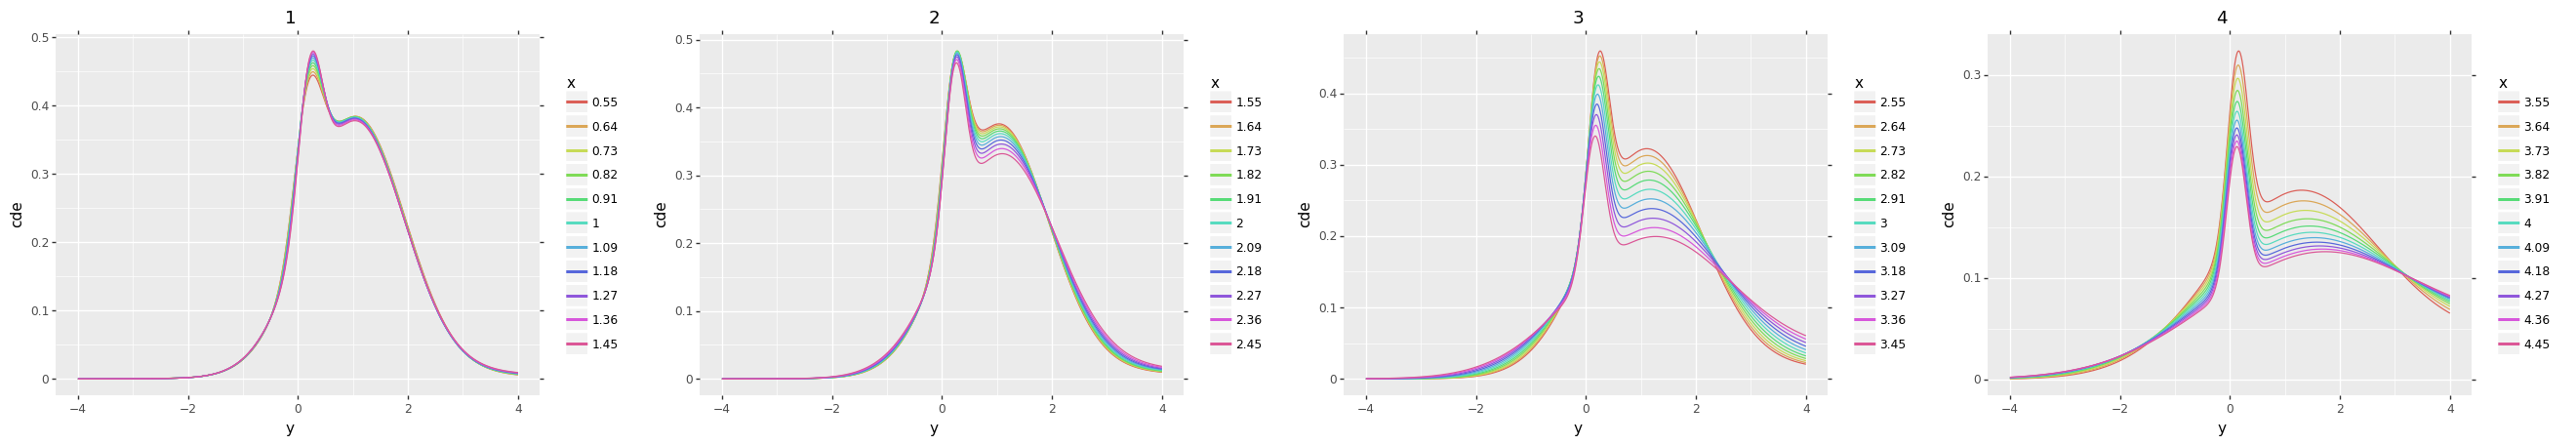

In [32]:
h_concat(my_img_cde_list)

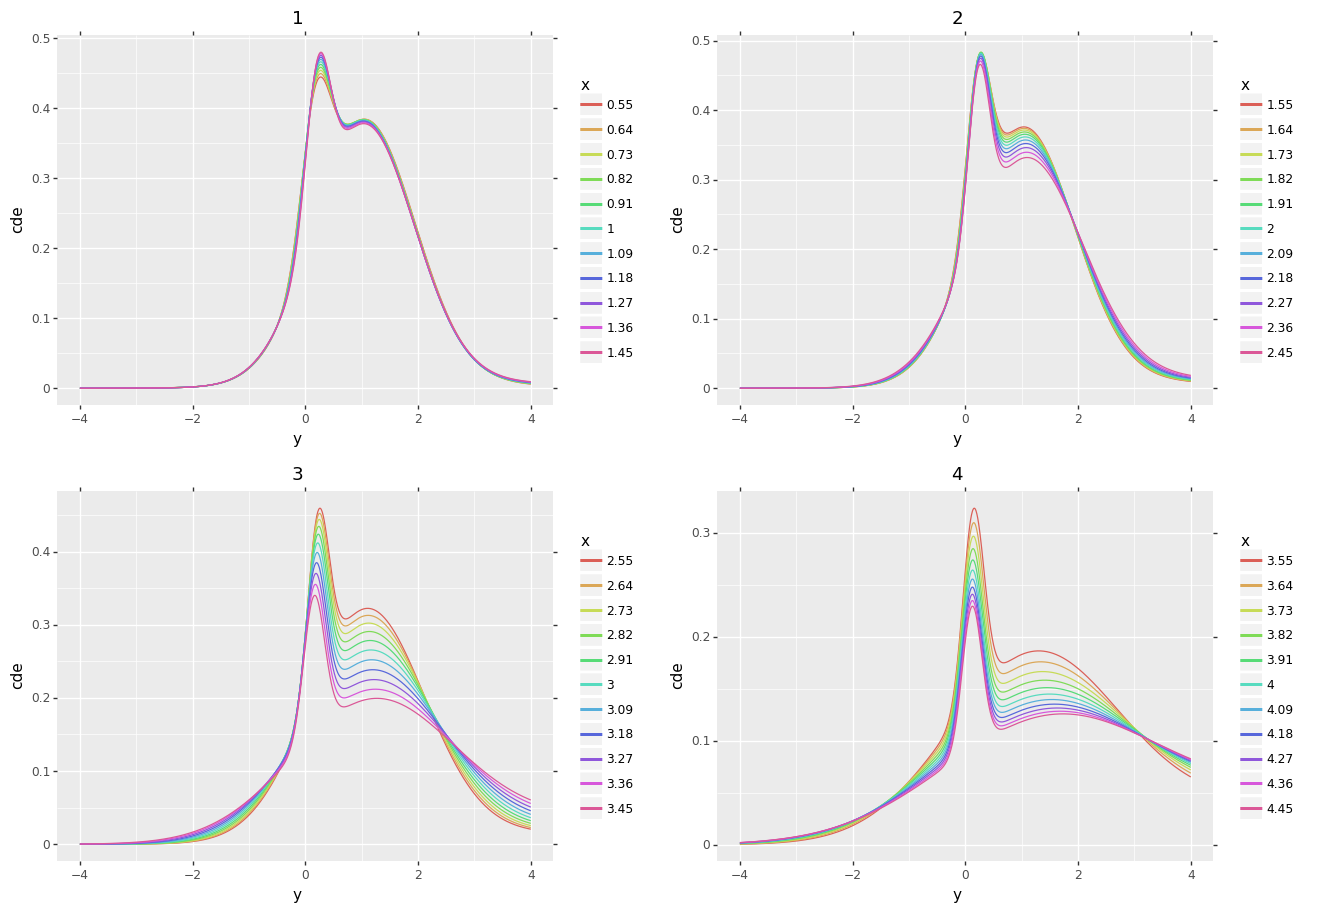

In [35]:
arrangegrob(gg_list, nrow = 2)

In [24]:
myvis = p9.ggplot(d_out) +\
    p9.geom_line(p9.aes(x="y",y="cde", color = "x")) 

#myvis

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


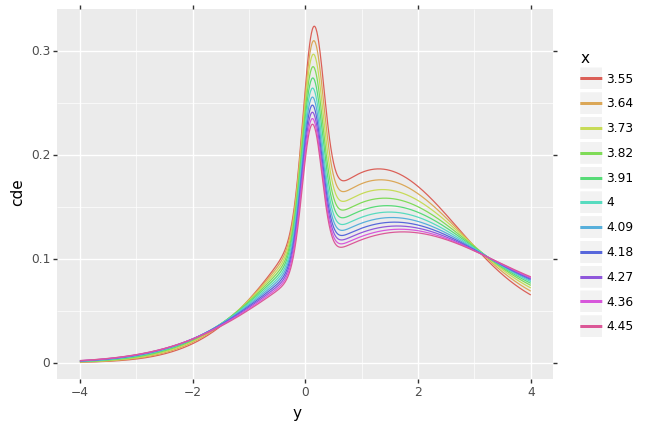

<ggplot: (-9223363264490282180)>

In [25]:
myvis

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: <_io.BytesIO object at 0x7fa79ab68048>
  warn('Filename: {}'.format(filename))
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/ggplot.py:722: 

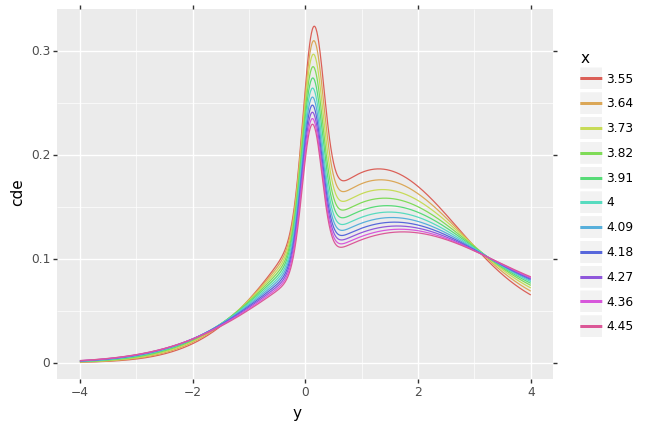

In [26]:
my_img = gg2img(myvis)
my_img

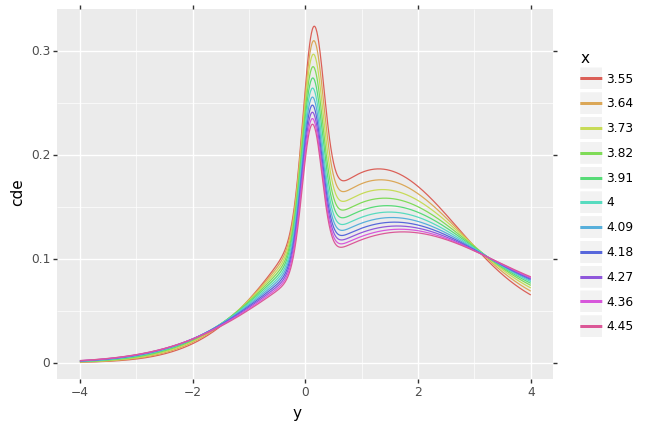

In [27]:
my_img

### Exploring CDE grid estimation and straight CDE prediction

Visual checks look good!

In [28]:
mdn_model.prep_for_cde(y_train_torch, 
                       n_grid = 1000)

In [29]:
out = mdn_model.cde_predict_grid(x_train_torch)

In [37]:
delta_y = ((mdn_model.y_range[1] - mdn_model.y_range[0])/ mdn_model.n_grid).numpy()

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


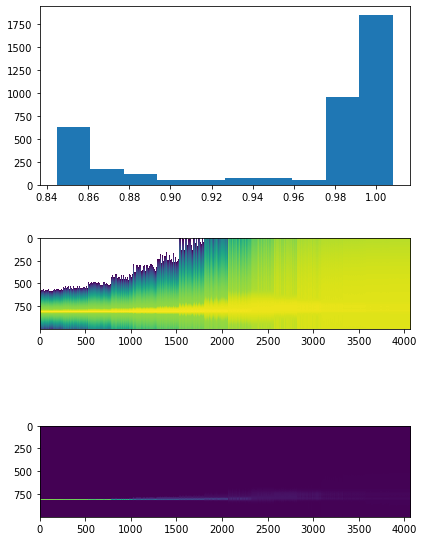

In [38]:
fig, ax = plt.subplots(nrows = 3, figsize = (6,8))

ax[0].hist(out.detach().numpy().sum(axis = 1)*delta_y)
ax[1].imshow(np.log(out.detach().numpy()).T[::-1,:])
ax[2].imshow(out.detach().numpy().T[::-1,:])
fig.tight_layout()

In [39]:
out_vec = mdn_model.cde_predict(x_train_torch, y_train_torch)

In [40]:
vdf = pd.DataFrame(data = {
    "x": x_train_torch.numpy().reshape(-1),
    "y": y_train_torch.numpy().reshape(-1),
    "log(cde)": np.log(out_vec.detach().numpy().reshape(-1))})

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


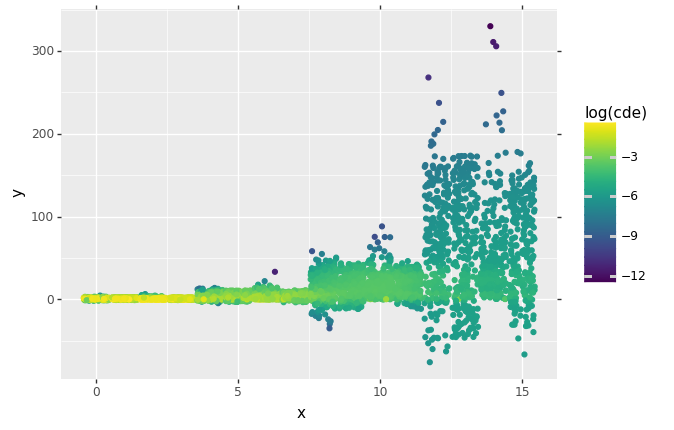

<ggplot: (-9223363264489183372)>

In [41]:
p9.ggplot(vdf) +\
    p9.geom_point(p9.aes(x="x", y="y", color = "log(cde)"))

## Quantile Perceptron

Updated code from: https://github.com/ceshine/quantile-regression-tensorflow/blob/master/notebooks/03-sklearn-example-pytorch.ipynb

In [47]:
class QuantilePerceptron(nn.Module):
    def __init__(self, 
                 n_hidden1,
                 n_hidden2,
                 quantiles):
        """
        create a multiple hidden layer Quantile Perceptron for a 1D input 
        (each quantile output is also in 1D space).
        
        Args:
        -----
        n_hidden1: int, number of nodes in the first hidden layer
        n_hidden2: int, number of nodes in the second hidden layer
        quantiles: 1d Tensor of quantiles (between 0 and 1)
        
        """
        super().__init__()
        if type(quantiles) is np.ndarray:
            self.quantiles = torch.from_numpy(quantiles).float()
        else:
            self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        
        self.build_model()
        self.init_weights()
        
    def build_model(self): 
        self.base_model = nn.Sequential(
            nn.Linear(1, self.n_hidden1),
            nn.ReLU(), 
            nn.Linear(self.n_hidden1, self.n_hidden2),
            nn.ReLU(),
            nn.Linear(self.n_hidden2, self.num_quantiles)
        )
        
    def init_weights(self):
        for m in self.base_model:
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight)
                nn.init.constant_(m.bias, 0)        
        
    def forward(self, x):
        return self.base_model(x)
        
    
    def loss_fn(self, preds, target):
        """
        Computes the quantile regression loss across predicts from model and 
        true values.
    
        
         Args:
        -----
        preds: predicted quantiles from model (n, num_quantiles)
        target: potential vector of targe (y) values (n, 1) torch.Tensor
        """
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        
        losses = torch.max(
                     torch.mul(self.quantiles, target - preds),
                     torch.mul(self.quantiles-1, target - preds)
                )
        loss = torch.mean(torch.sum(losses, dim = 1))
        return loss

In [43]:
# basic testing of loss function
preds = torch.from_numpy(np.arange(20).reshape((5,4))).float()
target = torch.from_numpy(np.arange(5).reshape((5,1))).float()
quantiles = torch.from_numpy(np.arange(1,5)/5)

def loss_fn2(quantiles, preds, target):
        """
        Computes the quantile regression loss across predicts from model and 
        true values.
    
        
         Args:
        -----
        preds: predicted quantiles from model (n, num_quantiles)
        target: potential vector of targe (y) values (n, 1) torch.Tensor
        """
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(quantiles):
            errors = target.reshape(-1) - preds[:, i]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss
    
def loss_fn(quantiles, preds, target):
        """
        Computes the quantile regression loss across predicts from model and 
        true values.


         Args:
        -----
        preds: predicted quantiles from model (n, num_quantiles)
        target: potential vector of targe (y) values (n, 1) torch.Tensor
        """
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)

        losses = torch.max(
                     torch.mul(quantiles, target - preds),
                     torch.mul(quantiles-1, target - preds)
                )
        loss = torch.mean(torch.sum(losses, dim = 1))
        return loss
    
myloss = loss_fn(quantiles, preds, target) 
old_loss = loss_fn2(quantiles, preds, target)

assert myloss == old_loss, \
    "losses should return samee value"

In [44]:
def tune_second_nn(x_train, y_train, x_val, y_val, 
                  model_op_list = None, epochs=10000, 
                  n_hidden1=10,
                  n_hidden2 = 10, lr=1e-3, 
                  quantiles=torch.from_numpy(np.arange(1,20)/20),
                  verbose = False):
    """
    create and evalulate a Quantile Perceptron
    
    Args:
    -----
    x_train: torch.Tensor (n, 1), training x
    y_train: torch.Tensor (n, 1), training y
    x_val: torch.Tensor (m, 1), validation x
    y_val: torch.Tensor (m, 1), validation y
    model_op_list : list with model and optimizer already created - else 
        will create them ourselves (Default is: None)
    epochs : int number of epochs to train the model for
    n_hidden1 : int, number of nodes for first hidden layer
    n_hidden2 : int, number of nodes for second hidden layer
    lr : float, learning rate for the optimizer (default is Adam)
    quantiles : numpy or torch.Tensor (n,), quantile values we wish to examine -
        each value must be between 0 and 1.
    verbose : boolean, if we should be verbose about the learning across epochs.
    
    Returns:
    --------
    tuned model, associated optimizer, and validation error
    """
    # model creation if necessary ------
    if model_op_list is None:
        model = QuantilePerceptron(n_hidden1, n_hidden2, quantiles)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        model = model_op_list[0]
        optimizer = model_op_list[1]
    
    # verbosity for fit ------
    if verbose:
        bar = progressbar.ProgressBar(widgets = [ progressbar.Bar(),
                                              ' (', progressbar.ETA(), ", ", 
                                              progressbar.Timer(), ')'])
        epoch_iter = bar(np.arange(epochs))
    else:
        epoch_iter = range(epochs)
    
    # actual fit ------
    for epoch in epoch_iter:
        optimizer.zero_grad()
        preds = model(x_train)
        loss = model.loss_fn(preds, y_train)
        loss.backward()
        optimizer.step()
        
    # get validation error -------
    preds_v = model(x_val)
    error = model.loss_fn(preds_v, y_val)
    
    return model, optimizer, error

In [48]:
tune_out2 = tune_second_nn(x_train = x_train_torch, 
              y_train = y_train_torch, 
              x_val = x_val_torch, 
              y_val = y_val_torch, 
              model_op_list = None, 
              epochs=10000, 
              quantiles=np.arange(1,20)/20, 
              n_hidden1=10, 
              n_hidden2 = 10, 
              lr=1e-3, 
              verbose = True)

|#####################################| (Time:  0:00:33, Elapsed Time: 0:00:33)


### Visualizing fit...

Note that we aren't going to actually use these `x` and `y` values for our model, but they demonstrate that coded up description of the Quantile Perceptron is fine.

In [50]:
qmodel = tune_out2[0]
preds_val = qmodel(x_val_torch)

qdf = pd.DataFrame(preds_val.detach().numpy(),
                  columns = ["q"+str(round(q*100)) for q in qmodel.quantiles.numpy()])
qdf["x"] = x_val_torch.numpy()

In [51]:
qdf_long = qdf.melt(id_vars = "x",
                   value_vars = ["q"+str(round(q*100)) for q in qmodel.quantiles.numpy()],
                   var_name = "quantiles",
                   value_name = "value")

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


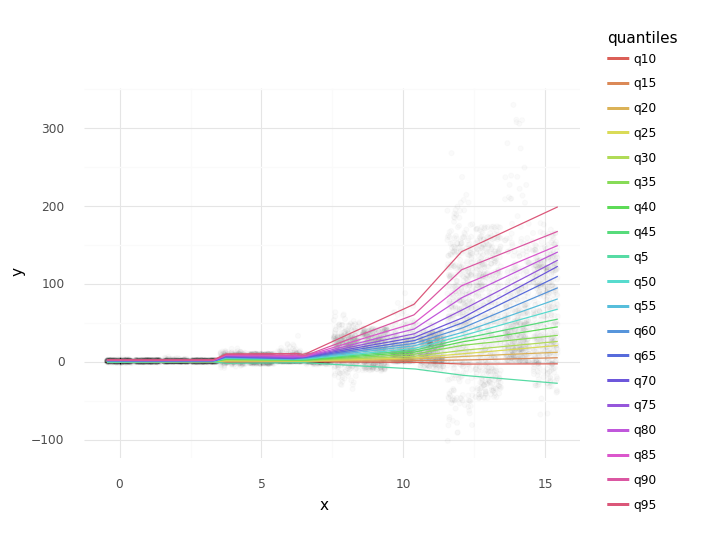

<ggplot: (-9223363264545287182)>

In [52]:
p9.ggplot(qdf_long) +\
    p9.geom_point(p9.aes(x="x",y="y"),
                  data = demo_data, alpha = .02) +\
    p9.geom_line(p9.aes(x = "x", y = "value", color = "quantiles")) +\
    p9.theme_minimal()

# Full Model Pipeline

In [53]:
def torchify_data(data):
    """
    make pandas dataframes with x,y columns in to torch objects x,y (n,1) shapes
    """
    x = torch.from_numpy(np.array(data.x).reshape((-1,1))).float()
    y = torch.from_numpy(np.array(data.y).reshape((-1,1))).float()
    
    return x,y

In [54]:
demo_data = data_generation(200,2)

data_all_splits = stratified_data_splitting(demo_data, group_col = 'group_info',
                         prop_vec = np.array([.25,.25, .25,.25]))

x_train, y_train = torchify_data(data_all_splits[0])
x_val, y_val = torchify_data(data_all_splits[1])
x_cde_val, y_cde_val = torchify_data(data_all_splits[2])
x_test, y_test = torchify_data(data_all_splits[3])

In [55]:
tune_info1 = tune_first_nn(x_train = x_train, y_train = y_train,
                          x_val = x_val, y_val = y_val,
                          epochs = 10000,
                          n_gaussians=1,
                          n_hidden1=10,
                          n_hidden2=10,
                          lr=1e-3,
                          verbose=True)

|#####################################| (Time:  0:00:19, Elapsed Time: 0:00:19)


In [56]:
mdn_model = tune_info1[0]

In [57]:
print(y_train.min(), y_train.max())
y_range_vec = torch.from_numpy(np.array([-20,20]).reshape((-1,1)))

tensor(-7.4934) tensor(14.7755)


In [58]:
mdn_model.prep_for_cde(y_range_vec, 1000)
cde_mat = mdn_model.cde_predict_grid(x_train).detach().numpy()
y_range = (mdn_model.y_range[0].detach().numpy(), 
           mdn_model.y_range[1].detach().numpy())
n_grid = mdn_model.n_grid
y_grid = np.linspace(y_range[0], y_range[1], n_grid)

In [59]:
hpd_cde_train = lc.hpd_coverage(cde_mat, y_grid, y_train.numpy())
hpd_cde_train_torch = torch.from_numpy(hpd_cde_train.reshape((-1,1)))

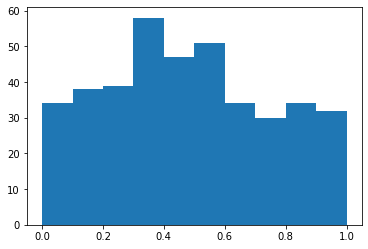

In [60]:
plt.hist(hpd_cde_train);

In [61]:
cde_mat_val = mdn_model.cde_predict_grid(x_val).detach().numpy()
hpd_cde_val = lc.hpd_coverage(cde_mat_val, y_grid, y_val.numpy())
hpd_cde_val_torch = torch.from_numpy(hpd_cde_val.reshape((-1,1)))

In [62]:
tune_info2 = tune_second_nn(x_train = x_train, y_train = hpd_cde_train_torch,
                          x_val = x_val, y_val = hpd_cde_val_torch,
                          epochs = 10000,
                          n_hidden1=10,
                          n_hidden2=10,
                          quantiles = np.arange(1,20)/20,
                          lr=1e-3,
                          verbose=True)

|#####################################| (Time:  0:00:11, Elapsed Time: 0:00:11)


In [63]:
q_model = tune_info2[0]

In [64]:
cuts = q_model(torch.from_numpy(np.array([1,2,3,4]).reshape((-1,1))).float())

In [66]:
qdf = pd.DataFrame(cuts.detach().numpy(),
                  columns = ["q"+str(round(q*100)) for q in q_model.quantiles.numpy()])
qdf["x"] = np.array([1,2,3,4])

In [67]:
qdf_long = qdf.melt(id_vars = "x",
                   value_vars = ["q"+str(round(q*100)) for q in q_model.quantiles.numpy()],
                   var_name = "quantiles",
                   value_name = "value")

In [70]:
qdf_long["q"] = [float(re.sub("q", "", x))/100 for x in np.array(qdf_long.quantiles)]

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


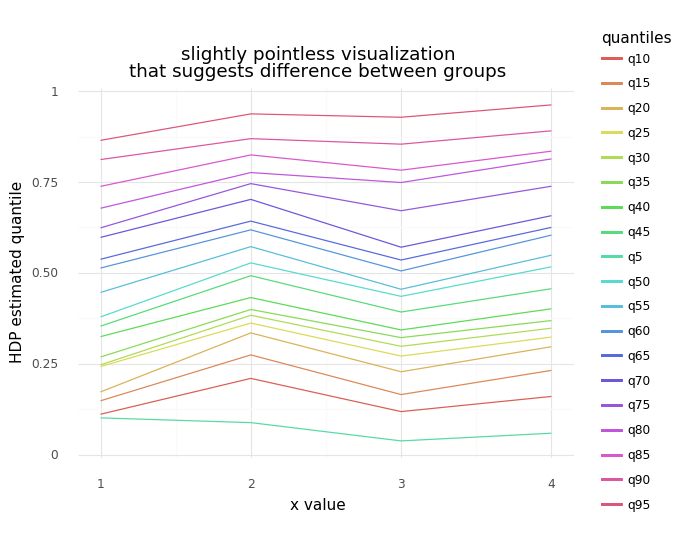

<ggplot: (-9223363264542502712)>

In [71]:
p9.ggplot(qdf_long) +\
    p9.geom_line(p9.aes(x = "x", y = "value", color = "quantiles")) +\
    p9.theme_minimal() +\
    p9.labs(x = "x value", y = "HDP estimated quantile",
            title = "slightly pointless visualization\nthat suggests difference between groups")

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:54: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(val) and not is_string(val):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


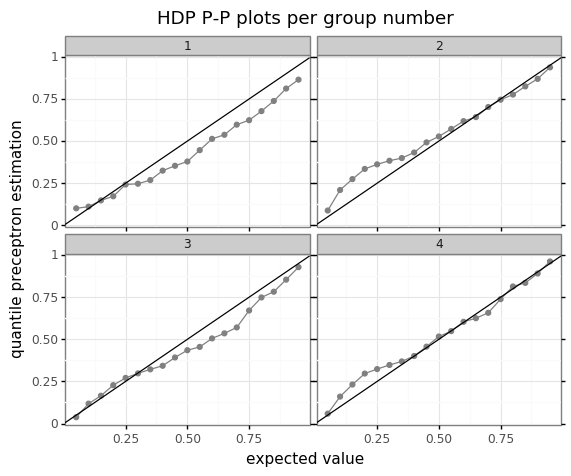

<ggplot: (8772315698482)>

In [72]:
p9.ggplot(qdf_long) +\
    p9.geom_line(p9.aes(x = "q", y = "value"), color = "grey") +\
    p9.geom_point(p9.aes(x = "q", y = "value"), color = "grey") +\
    p9.theme_bw() +\
    p9.facet_wrap("x") +\
    p9.geom_abline(slope = 1, intercept = 0) +\
    p9.labs(x = "expected value", y = "quantile preceptron estimation",
            title = "HDP P-P plots per group number")